In [1]:
from preamble import *

In [2]:
df = pd.read_csv('./data/j_weather_data.csv', index_col=0)
print(type(df), df.shape)

<class 'pandas.core.frame.DataFrame'> (15739, 7)


In [3]:
df.head()

,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow,output_flow
2023-01-01 00:00:00,-0.9,0.0,1.4,72.0,1023.6,0.0,6063.02
2023-01-01 01:00:00,-1.3,0.0,1.5,74.0,1023.3,0.0,7195.35
2023-01-01 02:00:00,-1.7,0.0,1.4,75.0,1023.1,0.0,7472.46
2023-01-01 03:00:00,-2.0,0.0,1.2,77.0,1023.3,0.0,4809.88
2023-01-01 04:00:00,-2.0,0.0,1.7,79.0,1022.8,0.0,6292.50


In [4]:
df_reset = df.reset_index(drop=True)
feature = df_reset.drop(columns=['output_flow'])
target = df['output_flow'].values.reshape(-1, 1)
feature.shape, target.shape

((15739, 6), (15739, 1))

In [5]:
feature

,temperature,precipitation,wind_speed,humidity,atmospheric_pressure,snow
0,-0.9,0.0,1.4,72.0,1023.6,0.0
1,-1.3,0.0,1.5,74.0,1023.3,0.0
2,-1.7,0.0,1.4,75.0,1023.1,0.0
3,-2.0,0.0,1.2,77.0,1023.3,0.0
4,-2.0,0.0,1.7,79.0,1022.8,0.0
...,...,...,...,...,...,...
15734,25.7,0.0,0.9,52.0,1013.3,0.0
15735,26.0,0.0,0.2,47.0,1013.0,0.0
15736,26.1,0.0,0.3,49.0,1012.8,0.0
15737,25.3,0.0,0.2,51.0,1012.9,0.0


In [6]:
import torch
import torch.nn as nn

torch.__version__, torch.cuda.is_available()

('2.5.1', True)

In [7]:
train_size = int(feature.shape[0] * 0.7)

trainset_feature = feature[:train_size]
trainset_target = target[:train_size]
testset_feature = feature[train_size:]
testset_target = target[train_size:]
print(trainset_feature.shape, testset_feature.shape)

(11017, 6) (4722, 6)


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler_feature = MinMaxScaler()
train_feature_scaled = scaler_feature.fit_transform(trainset_feature)
test_feature_scaled = scaler_feature.transform(testset_feature)

scaler_target = MinMaxScaler()
train_target_scaled = scaler_target.fit_transform(trainset_target)
test_target_scaled = scaler_target.transform(testset_target)

In [9]:
from tqdm import tqdm

def split_dataset(data, target, seq_len):
  X, y  = [], []
  for i in tqdm(range(data.shape[0]-(seq_len))):
    X.append(data[i:i+seq_len, :]) 
    y.append(target[i+seq_len])
  return np.array(X), np.array(y)

seq_len = 60

In [10]:
X_train, y_train = split_dataset(train_feature_scaled, train_target_scaled, seq_len)

100%|██████████| 10957/10957 [00:00<00:00, 3652888.40it/s]


In [11]:
X_train.shape, y_train.shape

((10957, 60, 6), (10957, 1))

In [12]:
X_test, y_test = split_dataset(test_feature_scaled, test_target_scaled, seq_len)

100%|██████████| 4662/4662 [00:00<?, ?it/s]


In [13]:
# y_train = y_train.reshape(-1, 1)
# y_test = y_test.reshape(-1, 1)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10957, 60, 6), (10957, 1), (4662, 60, 6), (4662, 1))

In [15]:
X_train_tensor, y_train_tensor = torch.tensor(X_train).float(), torch.tensor(y_train).float()
X_test_tensor, y_test_tensor = torch.tensor(X_test).float(), torch.tensor(y_test).float()

In [16]:
from torch.utils.data import DataLoader, TensorDataset

loader_train = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True,
                                           batch_size=128)
loader_test = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), shuffle=False,
                                          batch_size=128)

In [17]:
class LSTMModel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    last_out = lstm_out[:, -1, :]
    out = self.fc(last_out)
    return out

input_size = 6
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)


In [18]:
for I, label in loader_train:
  print(model(I)[0], label[0])
  break

tensor([-0.1130], grad_fn=<SelectBackward0>) tensor([0.9854])


In [19]:
import torch.optim as optim

# loss_fn = torch.nn.MSELoss(reduction='mean')
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
num_epochs = 200
# loss_history = []
model.train()
model.to(device)
for epoch in range(num_epochs):
  running_loss = 0.0
  for X_batch, y_batch in loader_train:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    out = model(X_batch)
    loss = loss_fn(out, y_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  # loss_history.append(running_loss / len(loader_train.dataset))
  print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(loader_train.dataset):.8f}")

Epoch [1/200], Loss: 0.00199963
Epoch [2/200], Loss: 0.00000499
Epoch [3/200], Loss: 0.00000409
Epoch [4/200], Loss: 0.00000353
Epoch [5/200], Loss: 0.00000311
Epoch [6/200], Loss: 0.00000282
Epoch [7/200], Loss: 0.00000263
Epoch [8/200], Loss: 0.00000248
Epoch [9/200], Loss: 0.00000239
Epoch [10/200], Loss: 0.00000228
Epoch [11/200], Loss: 0.00000220
Epoch [12/200], Loss: 0.00000217
Epoch [13/200], Loss: 0.00000213
Epoch [14/200], Loss: 0.00000213
Epoch [15/200], Loss: 0.00000208
Epoch [16/200], Loss: 0.00000208
Epoch [17/200], Loss: 0.00000206
Epoch [18/200], Loss: 0.00000205
Epoch [19/200], Loss: 0.00000208
Epoch [20/200], Loss: 0.00000205
Epoch [21/200], Loss: 0.00000209
Epoch [22/200], Loss: 0.00000203
Epoch [23/200], Loss: 0.00000206
Epoch [24/200], Loss: 0.00000203
Epoch [25/200], Loss: 0.00000208
Epoch [26/200], Loss: 0.00000203
Epoch [27/200], Loss: 0.00000206
Epoch [28/200], Loss: 0.00000204
Epoch [29/200], Loss: 0.00000212
Epoch [30/200], Loss: 0.00000209
Epoch [31/200], Los

In [22]:
model.eval()

y_pred_list = []
with torch.no_grad():
  for X_batch, _ in loader_test:
    X_batch = X_batch.to(device)
    # y_pred = model(X_batch).numpy()
    y_pred = model(X_batch).cpu().numpy()
    y_pred_list.append(y_pred)

y_pred = np.concatenate(y_pred_list, axis=0)

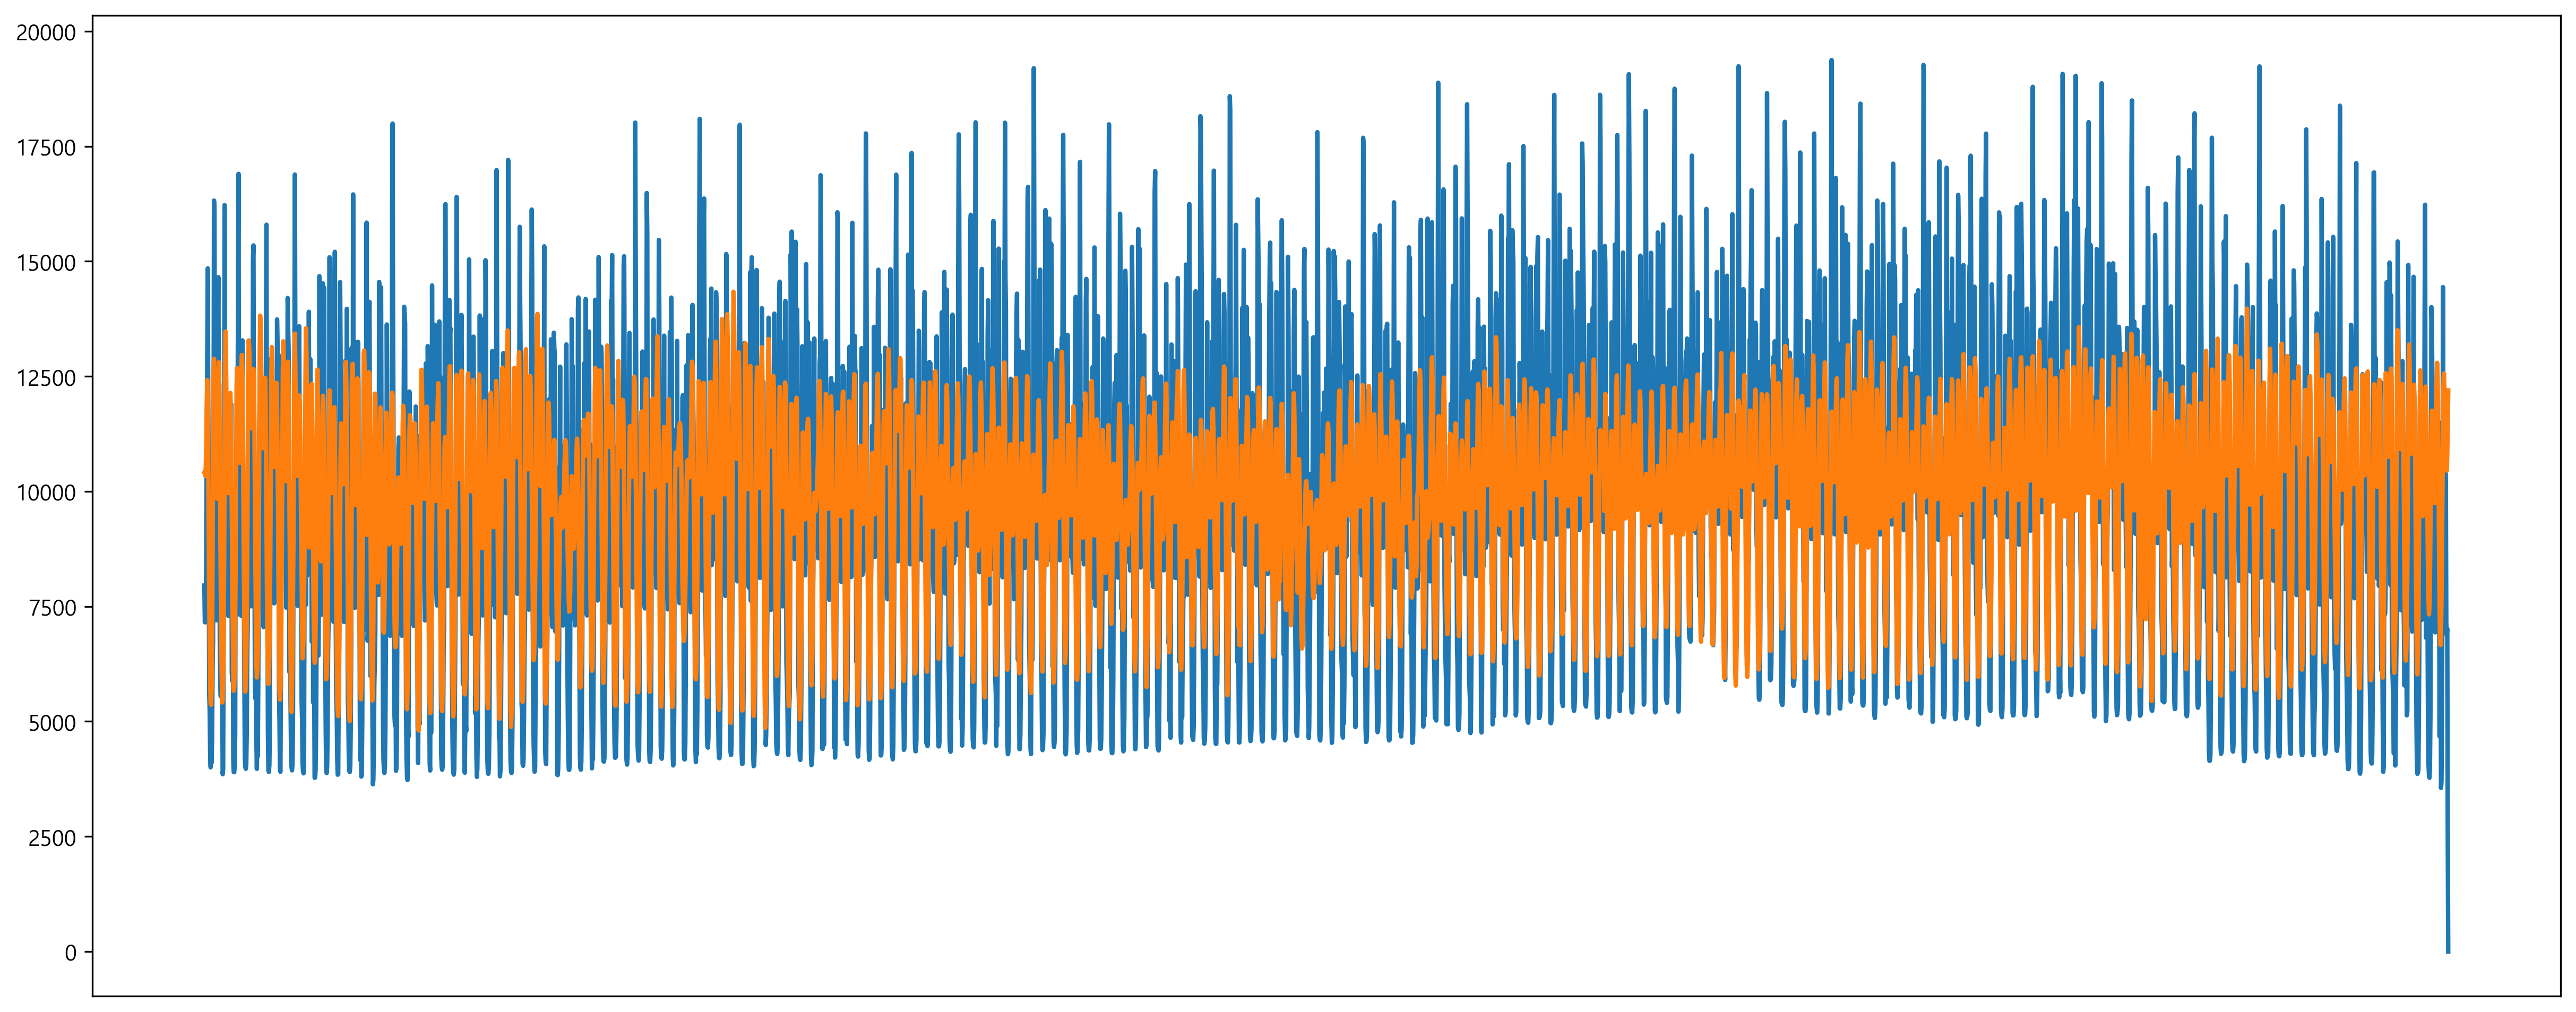

In [23]:
import matplotlib.pyplot as plt

y_test_ori = scaler_target.inverse_transform(y_test)
y_pred_ori = scaler_target.inverse_transform(y_pred)

plt.figure(figsize=(20, 8))
plt.xticks([])
plt.plot(df.index[train_size + seq_len:], y_test_ori)
plt.plot(df.index[train_size + seq_len:], y_pred_ori)
plt.show()